####  dataset https://www.consumerfinance.gov/data-research/
https://www.consumerfinance.gov/data-research/consumer-complaints/

What the consumers were complaining in the financial product and service market? 
Data from these complaints help us understand the financial marketplace and protect consumers.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SQLContext
#from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F
from pyspark.sql.functions import split, explode
#from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, TimestampType,ArrayType
from pyspark.ml.feature import Tokenizer, RegexTokenizer

NLP related installation and import

In [0]:
#word cloud
!pip install wordcloud
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [0]:
#!/bin/bash
!pip install nltk
!pip install --upgrade pip
!nltk.downloader all

import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
#stopwords = set(STOPWORDS) 
stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
#########
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data] Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /root/nltk_data...
[nltk_data] Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data] /root/nltk_data...
[nltk_data] Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Unzipping corpora/words.zip.
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data] Unzipping corpora/ieer.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Unzipping corpora/stopwords.zip.

In [0]:
#palette for seaborn
palette_colors = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878',
                    '#A040A0', '#F8D030','#E0C068','#EE99AC','#C03028', 
                    '#F85888', '#B8A038','#705898','#98D8D8','#7038F8']

#### 1.1 Data acquisition
- download [json format datasource](http://files.consumerfinance.gov/ccdb/complaints.json.zip) to local storage and unzip. Upload the unzipped json file to Databrick DBFS
- read json file

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

path,name,size
dbfs:/FileStore/tables/Matrices_for_ML_BB-1.ipynb,Matrices_for_ML_BB-1.ipynb,12948
dbfs:/FileStore/tables/Matrices_for_ML_BB.ipynb,Matrices_for_ML_BB.ipynb,12948
dbfs:/FileStore/tables/Unsupervised_Learning_PCA_BB.ipynb,Unsupervised_Learning_PCA_BB.ipynb,17665
dbfs:/FileStore/tables/complaints.csv,complaints.csv,1233411049
dbfs:/FileStore/tables/complaints.json,complaints.json,1942366519
dbfs:/FileStore/tables/exercise_pyspark_dataframe.ipynb,exercise_pyspark_dataframe.ipynb,30542
dbfs:/FileStore/tables/flight_model/,flight_model/,0
dbfs:/FileStore/tables/flight_weather.csv,flight_weather.csv,431664555


#####1.1.1 Pick up few data for observation.
Here we can see the 4 types of data data fields:
- date columns (yyyy-mm-dd format)
- some categorical columns
- narrative column (sentences)
- location related columns (state, zipcode)

In [0]:
# have quick view of the content of this json file
dbutils.fs.head("dbfs:/FileStore/tables/complaints.json", 4096)  

[Truncated to first 4096 bytes]
Out[7]: '[\n{"date_received": "2019-09-24", "product": "Debt collection", "sub_product": "I do not know", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt is not yours", "complaint_what_happened": "transworld systems inc. \\nis trying to collect a debt that is not mine, not owed and is inaccurate.", "company_public_response": "", "company": "TRANSWORLD SYSTEMS INC", "state": "FL", "zip_code": "335XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-24", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3384392"},\n{"date_received": "2019-09-19", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Incorrect information on your report", "sub_issue": "Information belongs to someone else", "complaint_what_happened": "", "company_public_response": "Company has responded to the consumer and the CFPB and chooses not to provide a public response", "company": "Experian Information Solutions Inc.", "state": "PA", "zip_code": "15206", "tags": "", "consumer_consent_provided": "Consent not provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-20", "company_response": "Closed with non-monetary relief", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3379500"},\n{"date_received": "2019-11-08", "product": "Debt collection", "sub_product": "I do not know", "issue": "Communication tactics", "sub_issue": "Frequent or repeated calls", "complaint_what_happened": "Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.", "company_public_response": "", "company": "Diversified Consultants, Inc.", "state": "NC", "zip_code": "275XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-11-08", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3433198"},\n{"date_received": "2021-01-28", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Problem with a credit reporting company\'s investigation into an existing problem", "sub_issue": "Investigation took more than 30 days", "complaint_what_happened": "", "company_public_response": "", "company": "EQUIFAX, INC.", "state": "FL", "zip_code": "33432", "tags": "", "consumer_consent_provided": "", "submitted_via": "Web", "date_sent_to_company": "2021-01-28", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "4102456"},\n{"date_received": "2019-09-15", "product": "Debt collection", "sub_product": "Other debt", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt was result of identity theft", "complaint_what_happened": "Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with auth

##### 1.1.2 load data into dataframe

In [0]:
from pyspark.sql.types import DateType
#json format data file has been uploaded to this folder
file_name = '/FileStore/tables/complaints.json'
schema = """ `date_received`  DATE, 
`product`  STRING, 
`sub_product`  STRING, 
`issue`  STRING, 
`sub_issue`  STRING, 
`complaint_what_happened`  STRING, 
`company_public_response`  STRING, 
`company`  STRING, 
`state`  STRING, 
`zip_code`  STRING, 
`tags`  STRING, 
`consumer_consent_provided`  STRING, 
`submitted_via`  STRING, 
`date_sent_to_company`  DATE, 
`company_response`  STRING, 
`timely`  STRING, 
`consumer_disputed`  STRING, 
`complaint_id`  STRING""" 
#For a regular multi-line JSON file, set the multiLine option to true.
sdf = spark.read.option("multiline",True).\
  json("/FileStore/tables/complaints.json", schema=schema)

#df = df.withColumn("complaint_id", df["complaint_id"].cast("bigint"))

##### 1.1.3 Have a quick view with the first several rows to make sure data has been loaded smoothly

In [0]:
#take 5 rows and have a clearer view with pandas dataframe
pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
date_received,2019-09-24,2019-09-19,2019-11-08,2021-01-28,2019-09-15
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Credit reporting, credit repair services, or o...",Debt collection
sub_product,I do not know,Credit reporting,I do not know,Credit reporting,Other debt
issue,Attempts to collect debt not owed,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...,Attempts to collect debt not owed
sub_issue,Debt is not yours,Information belongs to someone else,Frequent or repeated calls,Investigation took more than 30 days,Debt was result of identity theft
complaint_what_happened,transworld systems inc. \nis trying to collect...,,"Over the past 2 weeks, I have been receiving e...",,Pioneer has committed several federal violatio...
company_public_response,,Company has responded to the consumer and the ...,,,
company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"Diversified Consultants, Inc.","EQUIFAX, INC.",Pioneer Capital Solutions Inc
state,FL,PA,NC,FL,CA
zip_code,335XX,15206,275XX,33432,925XX


In [0]:
#total records and column counts
total = sdf.count()
print(("Total", total," records, ", len(sdf.columns), " columns"))

('Total', 1960448, ' records, ', 18, ' columns')

In [0]:
#data range
sdf.agg(F.max("date_sent_to_company"),F.min("date_sent_to_company"),F.max("date_received"),F.min("date_received")).show()

+-------------------------+-------------------------+------------------+------------------+
max(date_sent_to_company)|min(date_sent_to_company)|max(date_received)|min(date_received)|
+-------------------------+-------------------------+------------------+------------------+
 2021-02-06| 2011-12-01| 2021-02-06| 2011-12-01|
+-------------------------+-------------------------+------------------+------------------+

#### 1.2 Data cleansing
- Check date range, only keep the sent date from 2012-01-01 to 2019-12-31 (keep full-year data and exclude influence of covid-19)
- Delete data withought primary key (Complaint ID)
- remove empty states and outliers name
- drop null value of specific columns

In [0]:
# delete null rows of these categorical columns, delete empty state and an outlier
sdf = sdf.filter("date_received>'2011-12-31' " + # and date_received<'2020-01-01'
        "and state !='' and state!='UNITED STATES MINOR OUTLYING ISLANDS' ").\
        dropna(subset=['complaint_id', 'issue','product','date_received','company','state','submitted_via'])
# save cleaned data to table.

#### 1.2 Feature engineering

##### 1.2.1 features
- Add the length of the complaint content as a new feature named **complaint_len** 
- Add **weekday_received** to show weekday number of the **weekday_received** column
- Processing date type columns
- What's the most complaint day in a week
- Merge **Credit card or prepaid card	** and **Credit card or prepaid card	**  of the product feature

In [0]:
from pyspark.sql import functions
from pyspark.sql.functions import date_format

sdf = sdf.withColumn("complaint_length", functions.length(F.col("complaint_what_happened"))).\
  withColumn("weekday_received", date_format(F.col("date_received"), "u")). \
  withColumn("year_received", F.year("date_received")). \
  withColumn("product_merged", F.when(F.col('product').contains("Credit card"), "Card").otherwise(F.col('product'))) 

##### 1.2.2 Drop unusful columns
- tags, date_sent_to_company, timely, consumer_consent_provided weill be dropped since they're less useful for the analysis in this project.
- save the final dataframe to temp view for further use

In [0]:
drop_column_list = ["tags","date_sent_to_company","timely","consumer_consent_provided"]
sdf = sdf.select([column for column in sdf.columns if column not in drop_column_list])
sdf.createOrReplaceTempView('t_complaints')

#### 2.1 Data visualization

#####2.1.1 What are the most complained by multiple dimensions, have they changed over time. 
- by product by year
- by submitted channel by year

Define functions for process dataset and generating chart. The same function can be apply on other categorical columns such as company, issue, and etc.
The logic of the function is group by specific dimension and year and count complaints with ordered by complaints amount and get the first 4 ranked data.
With this function, we can see the top ranked complaints by specific dimension, and if the value of this dimension changed over years.

In [0]:
#we need to count group by year by each dimension, get the top rank items in each year, and visualize them with grouped chart. The below functions are for dealing with this issue. genChart
# for generating chart dataset
#generate group bar chart
def genBarchart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.factorplot(x="sent_year", y="count", data=df, aspect=3.0, kind='bar',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))
    
def getRankByYear(field_name, top_n=4):
  #top n complaints amount by year by field_name
  df_topn = sqlContext.sql("SELECT year(date_received) as sent_year," + \
                  field_name +\
                  " ,count(1) AS count " +\
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received)," + field_name)
  w = Window.partitionBy("sent_year").orderBy(F.col("count").desc())
  df_topn_pd = df_topn.select("*",F.row_number().over(w).alias('rank')).\
    filter(F.col('rank') <= top_n).orderBy(F.col("sent_year")).toPandas()
  return df_topn_pd

###### 2.1.1.1 Where did the complaints come from? Did that changed over time?

In [0]:
genBarchart("channel", "submitted_via")

###### 2.1.1.2 Which products get the most complaints? Have it changed over time?

In [0]:
#show name and column name
genBarchart("product", "product_merged",6)

###### 2.1.1.3 Where are the complaints from
From annually top N rank of complaints amount by states, we can see
- the amount of complaints are all increased during the analysis period
- compare to the other top-ranked states which have shown slowdown in total complaints since 2017, the FL states shows rapid growth during the period given.
- the top N ranked states chart shows that the amount of complaints in the state is proportional to that of the population

In [0]:
#show name and column name
genBarchart("company", "company",6)

In [0]:
#group count by year by states and save the result to temp view: t_state_count
sdf_state_count = sqlContext.sql("SELECT year_received,state,count(1) AS count " + \
                  " FROM t_complaints " +\
                  " GROUP BY year_received,state")

In [0]:
#top 8 complaints amount
'''
sqlContext.sql("SELECT product,count(1) AS count " + \
                     "FROM t_complaints where year_received>=2014 GROUP BY product" ).\
                     toPandas().sort_values(by=['count'],ascending=False)[:8]
'''

###### 2.1.1.4 What the consumers's voice about **Credit card collection**? (NLP)
According to the above top complained product, we see **Debt collection** ranked the second complained product in the last 4 years during the period survey. What's the issues in it.
- There are many kinds of issues of these complaints data. Let's try to extract essential words from the detail of these issues.

What part improved of the card product in 2014 compares to that of 2013

We start with the **complaint_what_happened**, split the sentences into words tokenizer, and hash the sentences into a feature vector. and generate feature vectors for machine learning instead of using the text as features.

In [0]:
# get narrative column during specific period
sdf_content = sqlContext.sql(\
                          " SELECT year_received,complaint_what_happened as content " +\
                          " FROM t_complaints WHERE " +\
                          " product_merged='Card' AND " +\
                          " (year_received >=2020) AND " +\
                          " complaint_what_happened IS NOT NULL AND " +\
                          " complaint_what_happened !='' ")

#可以只提取名词吗
vstopwords = np.append(stopwords,["x","xx","xxx","xxxx","xxxxx","xxxxxxxx","xx/xx/xxxx"])
#extract content from specific field of the dataframe, and return 
def parseContent(sdf_content):
  #lower 
  sdf_content = sdf_content.select("year_received","content", (F.lower(F.regexp_replace(F.col("content"), 
                                                                         "[^a-zA-Z\\s]", "")).alias('out1')))
  #split story into words
  tokenizer = Tokenizer(inputCol="out1", outputCol="out2")
  #private infor has been replaced with x before the dataset published, such as date, name...
  #remove stop words
  stopWordsRemover = StopWordsRemover(inputCol='out2', outputCol='out3' ,stopWords=stopwords)
  #stem
  # keep English words with length greater than 3
  stemmer = SnowballStemmer('english')
  udf_stem = udf(lambda words: [stemmer.stem(word) for word in words if len(word)>3 and word in english_words and \
                               word in nltk.pos_tag(tokenized) if(pos[:2] == 'NN') ], ArrayType(StringType()))
  #pipeline
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover])
  return pipeline.fit(sdf_content).transform(sdf_content) \
      .select("year_received","content","out3") \
      .drop("out1","out2") \
      .withColumn("words", udf_stem(F.col("out3"))).drop('out3')

#parse long text
sdf_content = parseContent(sdf_content)
#get a small proportion
df_content_2013 = sdf_content.filter(sdf_content.year_received==2013). \
  select(explode("words").alias('word')).\
  groupby('word').count().sort(F.desc("count")).toPandas()

#show word cloud
%matplotlib inline
#combine word and count column to map, and parse it to wordcloud
#data = dict(zip(df_word_count.select('word').collect(),df_word_count.select('count').collect()))
#wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)
wc = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(df_content_2013[0:200].to_string()) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

##### 2.1.2 complaints amount by week

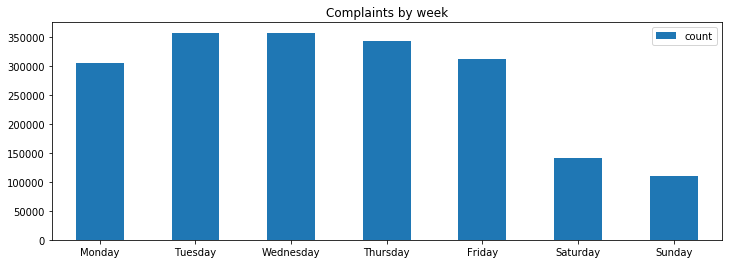

In [0]:
%matplotlib inline
#count complaints group by day of week
df_chart = sdf.groupBy("weekday_received")\
  .agg({"weekday_received":"count"})\
  .withColumnRenamed("count(weekday_received)", "count").toPandas()

ax = df_chart.sort_values(by=['weekday_received']).plot.bar(x='weekday_received', y='count', \
                                                            title='Complaints by week',figsize=(12,4), rot=0)
# show week labels
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('')
plt.figure(figsize=(10,4))

plt.show()

##### 2.1.3 how the company respond
The company handle the complaint in different ways, let see the relief way.

In [0]:
#what kinds of response
display(sdf.groupBy("product_merged","company_response").count())

product_merged,company_response,count
Card,Closed with monetary relief,34906
"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,539928
Consumer Loan,Closed with relief,88
Debt collection,Closed,7130
Bank account or service,Closed with explanation,55871
Money transfers,Closed,60
Student loan,Closed with non-monetary relief,4077
Checking or savings account,Closed with non-monetary relief,2828
Vehicle loan or lease,Closed with monetary relief,1017
"Payday loan, title loan, or personal loan",Closed with monetary relief,774


In [0]:
# is the 
df_company_response_by_year = pd.pivot_table(sdf.groupBy("year_received","company","company_response").count().toPandas(),\
               values = 'count', index=['year_received','company'], columns = 'company_response').reset_index()

In [0]:
df_tmp = sdf.select("company","product_merged","year_received","company_response").\
  where("company_response = 'Closed with monetary relief' or company_response = 'Closed with monetary relief' or " + \
        ""
       ).\
  groupby("company","product_merged","year_received","company_response").count().toPandas()


In [0]:
df_product_relief = pd.pivot_table(df_tmp,\
               values = 'count', index=['year_received','company','product_merged'], columns = 'company_response').reset_index()
df_product_relief.sort_values("Closed with monetary relief",ascending=False)[:20]

company_response,year_received,company,product_merged,Closed with monetary relief
2241,2016,"CITIBANK, N.A.",Card,1653
3776,2018,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,1215
5074,2020,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,1059
4441,2019,"BANK OF AMERICA, NATIONAL ASSOCIATION",Checking or savings account,994
1533,2015,"CITIBANK, N.A.",Card,976
2167,2016,"BANK OF AMERICA, NATIONAL ASSOCIATION",Bank account or service,898
4045,2018,JPMORGAN CHASE & CO.,Checking or savings account,880
5119,2020,CAPITAL ONE FINANCIAL CORPORATION,Card,879
4691,2019,JPMORGAN CHASE & CO.,Checking or savings account,865
388,2013,"CITIBANK, N.A.",Card,844


In [0]:

pd.pivot_table(sdf.groupBy("year_received","company","company_response").count().toPandas(),\
               values = 'count', index=['year_received','company'], columns = 'company_response').reset_index()
Closed with monetary relief

In [0]:
df_company_response_by_year.sort_values("Closed with monetary relief",ascending=False)[:20]

company_response,year_received,company,,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Closed with relief,Closed without relief,In progress,Untimely response
7562,2016,"CITIBANK, N.A.",NaN,8.0,4788.0,2166.0,1653.0,NaN,NaN,NaN,NaN
20069,2020,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,NaN,5583.0,2138.0,689.0,NaN,NaN,498.0,3.0
13687,2018,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,NaN,5292.0,1995.0,604.0,NaN,NaN,NaN,2.0
10430,2017,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,5.0,6017.0,1827.0,692.0,NaN,NaN,NaN,NaN
16926,2019,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,NaN,4775.0,1738.0,581.0,NaN,NaN,NaN,NaN
7391,2016,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,120.0,7114.0,1579.0,875.0,NaN,NaN,NaN,NaN
4433,2015,"BANK OF AMERICA, NATIONAL ASSOCIATION",NaN,274.0,6863.0,1439.0,1128.0,NaN,NaN,NaN,NaN
14918,2018,JPMORGAN CHASE & CO.,NaN,NaN,6354.0,1395.0,766.0,NaN,NaN,NaN,NaN
21236,2020,JPMORGAN CHASE & CO.,NaN,NaN,6772.0,1366.0,617.0,NaN,NaN,19.0,NaN
11651,2017,JPMORGAN CHASE & CO.,NaN,7.0,6325.0,1345.0,551.0,NaN,NaN,NaN,NaN


In [0]:
df_company_response_by_year.sort_values("Closed with monetary relief",ascending=False)[:20].\
  pivot(index='year_received', columns='year_received', values='Closed with monetary relief').plot()

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-48726519123558> in <module> 
 1 df_company_response_by_year . sort_values ( "Closed with monetary relief" , ascending = False ) [ : 20 ] . \ 
 ----> 2 pivot ( index = 'year_received' , columns = 'year_received' , values = 'Closed with monetary relief' ) . plot ( ) 

 /databricks/python/lib/python3.7/site-packages/pandas/core/frame.py in pivot (self, index, columns, values) 
 5626 def pivot ( self , index = None , columns = None , values = None ) : 
 5627 from pandas . core . reshape . pivot import pivot
 -> 5628 return pivot ( self , index = index , columns = columns , values = values ) 
 5629 
 5630 _shared_docs['pivot_table'] = """

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/pivot.py in pivot (data, index, columns, values) 
 386 indexed = data._constructor_sliced(data[values].values,
 387 index=index)
 --> 388 return indexed . unstack ( columns ) 
 389 
 390 

 /databricks/python/lib/python3.7/site-packages/pandas/core/series.py in unstack (self, level, fill_value) 
 3299 """
 3300 from pandas . core . reshape . reshape import unstack
 -> 3301 return unstack ( self , level , fill_value ) 
 3302 
 3303 # ---------------------------------------------------------------------- 

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/reshape.py in unstack (obj, level, fill_value) 
 394 unstacker = _Unstacker(obj.values, obj.index, level=level,
 395 fill_value = fill_value , 
 --> 396 constructor=obj._constructor_expanddim)
 397 return unstacker . get_result ( ) 
 398 

 /databricks/python/lib/python3.7/site-packages/pandas/core/reshape/reshape.py in __init__ (self, values, index, level, value_columns, fill_value, constructor) 
 98 self . index = index . remove_unused_levels ( ) 
 99 
 --> 100 self . level = self . index . _get_level_number ( level ) 
 101 
 102 # when index includes `nan`, need to lift levels/strides by 1 

 /databricks/python/lib/python3.7/site-packages/pandas/core/indexes/multi.py in _get_level_number (self, level) 
 1116 if ( count > 1 ) and not is_integer ( level ) : 
 1117 raise ValueError('The name %s occurs multiple times, use a '
 -> 1118 'level number' % level)
 1119 try : 
 1120 level = self . names . index ( level ) 

 ValueError : The name year_received occurs multiple times, use a level number

#### 3.1 Machine learning

##### 3.1.1 Keep usful columns for prediction

In [0]:
sdf_ml = sqlContext.sql("SELECT issue,submitted_via,complaint_length,company_response FROM t_complaints WHERE product_merged='Card'")
total = sdf_ml.count()
print(("Total", total," records, ", len(sdf_ml.columns), " columns"))

('Total', 184601, ' records, ', 4, ' columns')

In [0]:
# features相关性
#https://stackoverflow.com/questions/51831874/how-to-get-correlation-matrix-values-pyspark
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)


##### 3.1.2 Convert categorical columns to numeric 
- process all categorical columns, generate _index column. Converts these columns of string values to label indexes.

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

#categorical string columns
cat_columns = ['issue','submitted_via','company_response']
#pipeline
#indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_columns, \
#            OneHotEncoder(inputCol=column, outputCol=column+"_encode"), \
#            VectorAssembler
            #CountVectorizer(inputCol="words", outputCol="features", vocabSize=4, minDF=1.0)
#           ]

#pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
#sdf = pipeline.fit(df).transform(sdf)


indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in cat_columns]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
assembler = VectorAssembler(inputCols=[['complaint_length']+encoder.getOutputCol() for encoder in encoders],outputCol="features")


assembler = VectorAssembler(inputCols = columns_to_use, outputCol = features)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
sdf_ml_transformed = pipeline.fit(sdf_ml).transform(sdf_ml)
          

##### 3.1.3 training and testing set

In [0]:
display(sdf_ml_transformed)

issue,submitted_via,complaint_length,company_response,issue_indexed,submitted_via_indexed,company_response_indexed,complaint_length_indexed,issue_indexed_encoded,submitted_via_indexed_encoded,company_response_indexed_encoded,complaint_length_indexed_encoded,features
Problem when making payments,Web,0,Closed with explanation,5.0,0.0,0.0,0.0,"List(0, 55, List(5), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(5, 55, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
Closing your account,Referral,0,Closed with explanation,8.0,1.0,0.0,0.0,"List(0, 55, List(8), List(1.0))","List(0, 5, List(1), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(8, 56, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
Problem when making payments,Web,0,Closed with explanation,5.0,0.0,0.0,0.0,"List(0, 55, List(5), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(5, 55, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
Getting a credit card,Web,1759,Closed with non-monetary relief,6.0,0.0,2.0,1614.0,"List(0, 55, List(6), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(2), List(1.0))","List(0, 5353, List(1614), List(1.0))","List(0, 5420, List(6, 55, 62, 1681), List(1.0, 1.0, 1.0, 1.0))"
Unexpected or other fees,Phone,0,Closed with explanation,33.0,2.0,0.0,0.0,"List(0, 55, List(33), List(1.0))","List(0, 5, List(2), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(33, 57, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
"Other features, terms, or problems",Web,0,Closed with explanation,2.0,0.0,0.0,0.0,"List(0, 55, List(2), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(2, 55, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
"Advertising and marketing, including promotional offers",Web,1626,Closed with monetary relief,11.0,0.0,1.0,1751.0,"List(0, 55, List(11), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(1), List(1.0))","List(0, 5353, List(1751), List(1.0))","List(0, 5420, List(11, 55, 61, 1818), List(1.0, 1.0, 1.0, 1.0))"
Problem with a purchase shown on your statement,Web,0,Closed with explanation,0.0,0.0,0.0,0.0,"List(0, 55, List(0), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(0, 55, 60, 67), List(1.0, 1.0, 1.0, 1.0))"
Problem with a purchase shown on your statement,Web,832,Closed with monetary relief,0.0,0.0,1.0,733.0,"List(0, 55, List(0), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(1), List(1.0))","List(0, 5353, List(733), List(1.0))","List(0, 5420, List(0, 55, 61, 800), List(1.0, 1.0, 1.0, 1.0))"
Problem with a purchase shown on your statement,Web,0,Closed with explanation,0.0,0.0,0.0,0.0,"List(0, 55, List(0), List(1.0))","List(0, 5, List(0), List(1.0))","List(0, 7, List(0), List(1.0))","List(0, 5353, List(0), List(1.0))","List(0, 5420, List(0, 55, 60, 67), List(1.0, 1.0, 1.0, 1.0))"


In [0]:
train_sdf, test_sdf = sdf_ml_transformed.randomSplit([0.8, 0.2], seed=42)


##### 3.1.4 LogisticRegression

In [0]:
#api https://spark.apache.org/docs/latest/ml-tuning.html
#这个是nlp相关的链接
#https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html
lr = LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
    .build()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cv_model = cv.fit(train_data)

#best model parameter
print(cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)])

##### 3.1.4 Random Forest

In [0]:
#https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
import sklearn 
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=500)
rfModel = rf.fit(train)
predictions_train = rfModel.transform(train_sdf)

y_true = predictions_train.select(['label']).collect()
y_pred = predictions_train.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

#### 1.3 Data transformation

In [0]:
import org.apache.spark.ml.feature.HashingTF

hashingTF = new HashingTF() \
  .setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(20)
lr = LogisticRegression(maxIter=7)
pipeline = Pipeline(stages=[hashingTF,lr])
# Fit the model to the data.
model = pipeline.fit(df_words)

# Given a dataset, predict each point's label, and show the results.
#model.transform(df_word).show()

##### 3.1.1 apply Logistic Regression

In [0]:
lr = LogisticRegression(maxIter=10)
# Fit the model to the data.
model = lr.fit(df)
# Given a dataset, predict each point's label, and show the results.
model.transform(df_word).show()

##### 2.2.4 Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

##### 2.2.5 summary report

In [0]:
sqlContext.sql("
               SELECT * product, year
               ")

##### 2.2.9 Let's generate words cloud to have a clear insight about the consumers' complaints
- split issue, sub_issue and narrative fields

##### Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

In [0]:
df_company_issue = sqlContext.sql("SELECT company,count(1) as count, " + \
                           " round((sum(IF(timely='No', 1, 0))/count(1))*100,2) as delay_percent " +\
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " GROUP BY company")
display(df_company_issue)

###### How can we look further?
- Using web crawler, check the user amount of this company. 
- Checking the narrative, generating words cloud to see.
- From time aspect, check whether these issued have been fixed. 

These top 3 companies all have timely response, so this time let's only focus on the amount about this issue during these years. 
The line chart shows, from 2015 by now, this issue has been increased gradually instead of improved. Since 2020, the complaints amount increased greatly.

In [0]:
df_company_improve = sqlContext.sql("SELECT company,date_received,to_timestamp(date_received, 'yyyy-MM') as received_ym," + \
                           " count(1) as total "         
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " AND ((company='TRANSUNION INTERMEDIATE HOLDINGS, INC.')  "
                           " OR (company='Experian Information Solutions Inc.')  "
                           " OR (company='EQUIFAX, INC.'))  "
                           " GROUP BY company,date_received,to_timestamp(date_received, 'yyyy-MM')")

display(df_company_improve)

#### 1.4 NLP
By taking some sampling data, we have seen what the data looks like.
- **complaint_what_happened** is the description of what that consumer complained. By applying nlp related analysis, can we find the sentiment of these records. This is all about complaints, but there usually exists different levels of severity. If we can analysis these levels, it might be useful for the future classification.
- Check the columns which have these standard items

- Clearing text from punctuation (regexp_replace)
 - Tokenization (Tokenizer)
 - Delete stop words (StopWordsRemover)
 - Stematization (SnowballStemmer)
 - Filtering short words (udf)

###NLP
-  DocumentAssembler(), one of the most essential transformers of the Spark NLP library. It’s the entry point to get your data in, and then process further with annotators. And, without linking its output to annotators in a pipeline, it has no meaning. In the following articles, we will talk about how you can apply certain NLP tasks on top of DocumentAssembler()

#### Where are these customers, in which way they complained.
 - using geo information to visualize the distribution of these consumers.
 - count the complaint record by source.

### 3 Machine Learning
- Can we predict the the sentiment of the consumers by extracting the story of these complaints.
- Can we predict the issue or product by extracting the consumer's story and other columns
- Can we predict the close type ?

#### 3.1 Feature processing
- Prepare features.

In [0]:
sdf.createOrReplaceTempView('t_complaints')
sdf.columns

In [0]:
#dataset for machine learning
sdf_ml = sqlContext.sql("SELECT product,issue,state,company,weekday_received,company_public_response " + \
                  " FROM t_complaints")

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(words)

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(words),y_train)

作者：炼己者
链接：https://www.zhihu.com/question/268849350/answer/488389597
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

In [0]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())
#these are some categorical string columns, add according code column to make it easier to process
#nominal columns
cat_columns = ['product',\
               'issue',\
               'state','company_response',\
               ,'company_public_response']
#ordinal columns 
#'weekday_received'
#pipeline
indexers = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in cat_columns]) 
pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
sdf_ml = pipeline.fit(df).transform(df)

#### 3.2 Buil the pipeline
- pipeline.....

#### 3.3 Evaluate the model
- pipeline.....

#### 3.4 Hyperparameter tuning
- tunning.....

#### 3.5 Make predictions and evaluate model performance
- prediction.....

In [0]:
#spark pipeline 
#http://kuanliang.github.io/2016-06-07-SparkML-pipeline/
tokenizer = Tokenizer(inputCol="seq", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(labelCol="class", regParam)
tokenizer.transform(training).show()

hashingTF.transform(tokenizer.transform(training)).show()
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
paraGrid = ParamGridBuilder().addGrid(
    hashingTF.numFeatures, [10, 100, 1000]
).addGrid(
    lr.regParam, [0.1, 0.01, 0.001]
).build()
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paraGrid,\
                    evaluator=BinaryClassificationEvaluator(labelCol="class", metricName="areaUnderPR"),\
                    numFolds=2)
cv_model = cv.fit(training)

cv_model.bestModel
cv_model.bestModel.stages
for stage in cv_model.bestModel.stages:
    print 'stage: {}'.format(stage)
    print stage.params
    print '\n'
    
stage1.getNumFeatures()
stage2.intercept
stage2.weights
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cv_model.transform(test)
selected = prediction.select('seq', 'probability', 'prediction')


##### 1.1.1 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.   + population
- input:big company, date, product type,least complained state
- output: state

less complaints=>more productive
- big company has sold A product. 100 people get it, 99%complained. than means product performs very bad here.
complaint rate of a product represent the performance of selling this product.

complaints /(product_sell_amount) =>performance

##### 1.1.2 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.  + population
- input:product,max complained state name, big company, date
- output: state
complaints rate!!!!不适合发布新产品

In [0]:
visualization
product==>least complaints /most complaints state 

预测是否max complaints
1、existing product==>which state wil have max complaints in  A specific 
基于历史数据最多抱怨的product 

In [0]:
Now, we are ready to create a pipeline with different stages. For out data so far, we just a single stage with the assember, however, you could have other stages before that where you perform operations on the data, e.g, transforming categorical strings to numeric values or feature scaling operations.

In this step, we will create a pipeline with a single stage - the assembler. Fit the pipeline to your data and create the transformed dataframe and name it 'modified_data_sdf'.

####Sample of machine learning

In [0]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
#Note the differences between ml and mllib, they are two different libraries.

#create a sample data frame
data = [(1.54,3.45,2.56,0),(9.39,8.31,1.34,0),(1.25,3.31,9.87,1),(9.35,5.67,2.49,2),\
        (1.23,4.67,8.91,1),(3.56,9.08,7.45,2),(6.43,2.23,1.19,1),(7.89,5.32,9.08,2)]

cols = ('a','b','c','d')

df = spark.createDataFrame(data, cols)

assembler = VectorAssembler(inputCols=['a','b','c'], outputCol='features')

df_features = assembler.transform(df)

#df.show()

train_data, test_data = df_features.randomSplit([0.6,0.4])

dtc = DecisionTreeClassifier(featuresCol='features',labelCol='d')

dtcModel = dtc.fit(train_data)

predictions = dtcModel.transform(test_data)